In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

In [ ]:
pd.set_option('display.max_rows', 500)

# Assignment 4 - Hypothesis Testing
This assignment requires more individual learning than previous assignments - you are encouraged to check out the [pandas documentation](http://pandas.pydata.org/pandas-docs/stable/) to find functions or methods you might not have used yet, or ask questions on [Stack Overflow](http://stackoverflow.com/) and tag them as pandas and python related. And of course, the discussion forums are open for interaction with your peers and the course staff.

Definitions:
* A _quarter_ is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December.
* A _recession_ is defined as starting with two consecutive quarters of GDP decline, and ending with two consecutive quarters of GDP growth.
* A _recession bottom_ is the quarter within a recession which had the lowest GDP.
* A _university town_ is a city which has a high percentage of university students compared to the total population of the city.

**Hypothesis**: University towns have their mean housing prices less effected by recessions. Run a t-test to compare the ratio of the mean price of houses in university towns the quarter before the recession starts compared to the recession bottom. (`price_ratio=quarter_before_recession/recession_bottom`)

The following data files are available for this assignment:
* From the [Zillow research data site](http://www.zillow.com/research/data/) there is housing data for the United States. In particular the datafile for [all homes at a city level](http://files.zillowstatic.com/research/public/City/City_Zhvi_AllHomes.csv), ```City_Zhvi_AllHomes.csv```, has median home sale prices at a fine grained level.
* From the Wikipedia page on college towns is a list of [university towns in the United States](https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States) which has been copy and pasted into the file ```university_towns.txt```.
* From Bureau of Economic Analysis, US Department of Commerce, the [GDP over time](http://www.bea.gov/national/index.htm#gdp) of the United States in current dollars (use the chained value in 2009 dollars), in quarterly intervals, in the file ```gdplev.xls```. For this assignment, only look at GDP data from the first quarter of 2000 onward.

Each function in this assignment below is worth 10%, with the exception of ```run_ttest()```, which is worth 50%.

In [2]:
# Use this dictionary to map state names to two letter acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

In [89]:
!cat university_towns.txt

Alabama[edit]
Auburn (Auburn University)[1]
Florence (University of North Alabama)
Jacksonville (Jacksonville State University)[2]
Livingston (University of West Alabama)[2]
Montevallo (University of Montevallo)[2]
Troy (Troy University)[2]
Tuscaloosa (University of Alabama, Stillman College, Shelton State)[3][4]
Tuskegee (Tuskegee University)[5]
Alaska[edit]
Fairbanks (University of Alaska Fairbanks)[2]
Arizona[edit]
Flagstaff (Northern Arizona University)[6]
Tempe (Arizona State University)
Tucson (University of Arizona)
Arkansas[edit]
Arkadelphia (Henderson State University, Ouachita Baptist University)[2]
Conway (Central Baptist College, Hendrix College, University of Central Arkansas)[2]
Fayetteville (University of Arkansas)[7]
Jonesboro (Arkansas State University)[8]
Magnolia (Southern Arkansas University)[2]
Monticello (University of Arkansas at Monticello)[2]
Russellville (Arkansas Tech University)[2]
Searcy (Harding University)[5]
California[edit]
Angwin (Pacific Union College

In [51]:
import re

def cleanName(value):
  cleanedText = re.split('[([]+', str(value))[0]
  return cleanedText.strip()

def get_list_of_university_towns():
    '''Returns a DataFrame of towns and the states they are in from the 
    university_towns.txt list. The format of the DataFrame should be:
    DataFrame( [ ["Michigan", "Ann Arbor"], ["Michigan", "Yipsilanti"] ], 
    columns=["State", "RegionName"]  )
    
    The following cleaning needs to be done:

    1. For "State", removing characters from "[" to the end.
    2. For "RegionName", when applicable, removing every character from " (" to the end.
    3. Depending on how you read the data, you may need to remove newline character '\n'. '''
    df = pd.read_csv("university_towns.txt", names = [ "RegionName" ], encoding='utf-8')
    df["State"] = df[df.RegionName.str.endswith("[edit]")]
    df["State"].fillna(method="ffill",inplace=True)
    df1 = df[df["RegionName"] != df["State"]].applymap(cleanName)
    # drop rows with [edit] in region name
    return df1

get_list_of_university_towns()

,RegionName,State
1,Auburn,Alabama
2,Florence,Alabama
3,Jacksonville,Alabama
4,Livingston,Alabama
5,Montevallo,Alabama
...,...,...
561,River Falls,Wisconsin
562,Stevens Point,Wisconsin
563,Waukesha,Wisconsin
564,Whitewater,Wisconsin


A recession is defined as starting with two consecutive quarters of GDP decline, and ending with two consecutive quarters of GDP growth.

In [5]:
gdplev = pd.ExcelFile('gdplev.xls')
# look at 2000q1 onwards
gdplev = gdplev.parse("Sheet1", skiprows=219)
gdplev.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,1999q4,9926.1,12323.3,Unnamed: 7
0,NaN,NaN,NaN,NaN,2000q1,10031.0,12359.1,NaN
1,NaN,NaN,NaN,NaN,2000q2,10278.3,12592.5,NaN
2,NaN,NaN,NaN,NaN,2000q3,10357.4,12607.7,NaN
3,NaN,NaN,NaN,NaN,2000q4,10472.3,12679.3,NaN
4,NaN,NaN,NaN,NaN,2001q1,10508.1,12643.3,NaN


In [6]:
gdplev = gdplev[['1999q4', 9926.1]]
gdplev.columns = ['Quarter','GDP']
gdplev.head(10)

,Quarter,GDP
0,2000q1,10031.0
1,2000q2,10278.3
2,2000q3,10357.4
3,2000q4,10472.3
4,2001q1,10508.1
5,2001q2,10638.4
6,2001q3,10639.5
7,2001q4,10701.3
8,2002q1,10834.4
9,2002q2,10934.8


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

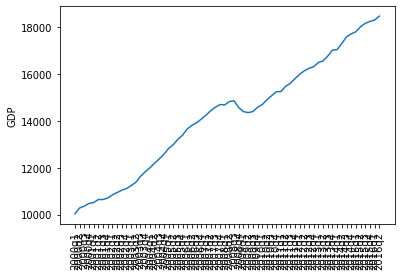

In [8]:
plt.plot(gdplev["Quarter"], gdplev.GDP)
plt.ylabel('GDP')
plt.xticks(gdplev["Quarter"], gdplev["Quarter"], rotation='vertical')
plt.show()

In [9]:
gdplev["diff2"] = gdplev.GDP.diff() 

In [10]:
gdplev[gdplev.diff2 < 0 ]

,Quarter,GDP,diff2
32,2008q1,14668.4,-16.9
35,2008q4,14549.9,-293.1
36,2009q1,14383.9,-166.0
37,2009q2,14340.4,-43.5


In [11]:
def isRecession(x):
  return 1 if x > 0 else -1


In [12]:
gdplev["diff3"] = gdplev.diff2.apply( isRecession )

In [13]:
gdplev

,Quarter,GDP,diff2,diff3
0,2000q1,10031.0,NaN,-1
1,2000q2,10278.3,247.3,1
2,2000q3,10357.4,79.1,1
3,2000q4,10472.3,114.9,1
4,2001q1,10508.1,35.8,1
...,...,...,...,...
61,2015q2,17998.3,214.7,1
62,2015q3,18141.9,143.6,1
63,2015q4,18222.8,80.9,1
64,2016q1,18281.6,58.8,1


In [14]:
gdplev["recession"] = gdplev.diff3.rolling(2).sum()

In [15]:
gdplev

,Quarter,GDP,diff2,diff3,recession
0,2000q1,10031.0,NaN,-1,NaN
1,2000q2,10278.3,247.3,1,0.0
2,2000q3,10357.4,79.1,1,2.0
3,2000q4,10472.3,114.9,1,2.0
4,2001q1,10508.1,35.8,1,2.0
...,...,...,...,...,...
61,2015q2,17998.3,214.7,1,2.0
62,2015q3,18141.9,143.6,1,2.0
63,2015q4,18222.8,80.9,1,2.0
64,2016q1,18281.6,58.8,1,2.0


In [ ]:
#gdplev.drop([ "diff3",	"recession",	"mark"], axis=1, inplace=True)

In [16]:
import matplotlib.pyplot as plt


In [17]:
rStart = gdplev.loc[gdplev.recession == -2].index[0] - 2
gdplev.iloc[rStart]["Quarter"]

'2008q3'

In [18]:
df2 = gdplev[rStart:]
rEnd = df2.loc[df2.recession == 2].index[1]
gdplev.iloc[rEnd]["Quarter"]

'2009q4'

In [19]:
df3 = gdplev[rStart:rEnd]
df3.loc[df3.GDP.idxmin(),"Quarter"]


'2009q2'

In [20]:
df3

,Quarter,GDP,diff2,diff3,recession
34,2008q3,14843.0,30.0,1,2.0
35,2008q4,14549.9,-293.1,-1,0.0
36,2009q1,14383.9,-166.0,-1,-2.0
37,2009q2,14340.4,-43.5,-1,-2.0
38,2009q3,14384.1,43.7,1,0.0


In [ ]:
#Start = gdplev.loc[gdplev.recession == -2].index[0] - 1
#df2 = gdplev[rStart:]
#rBottom = df2.loc[df2.diff3 == 1].index[0] - 1
#gdplev.iloc[rBottom]["Quarter"] 

'2009q2'

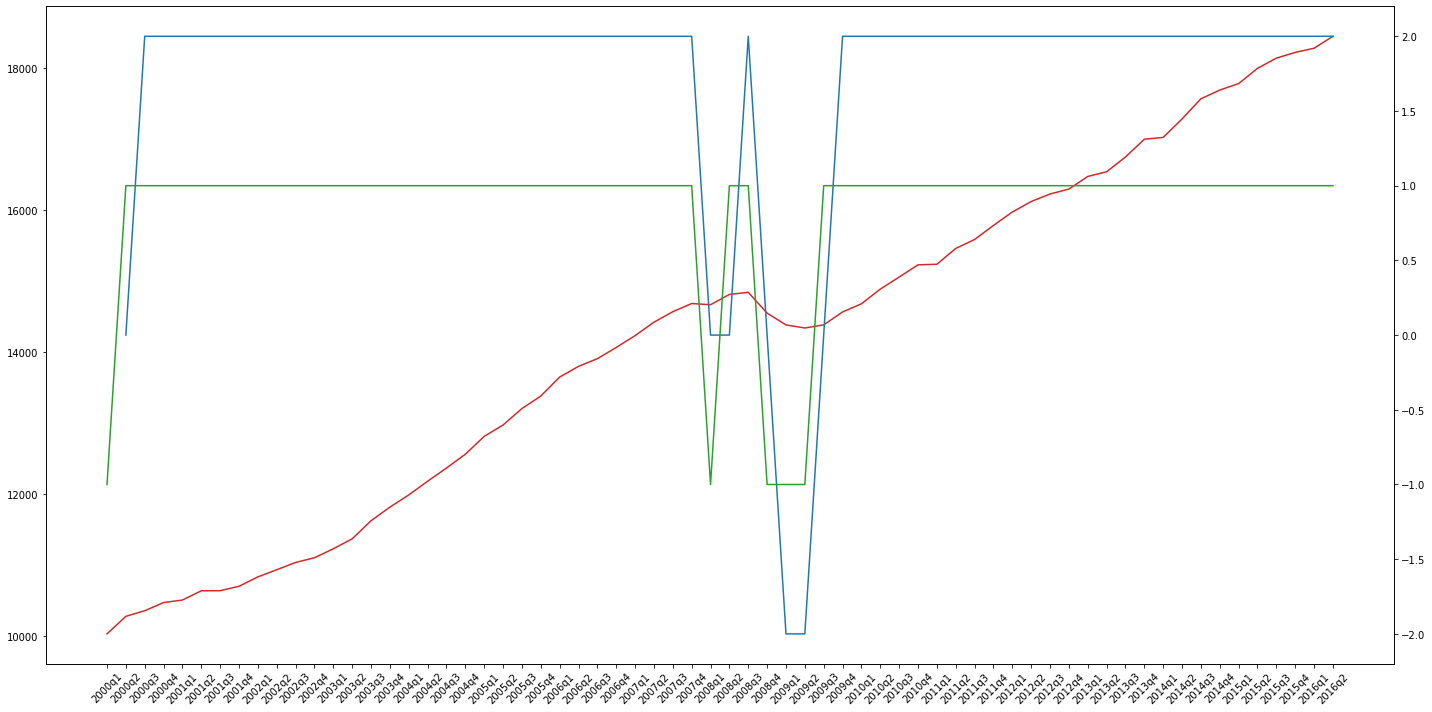

In [21]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(gdplev["Quarter"], gdplev.GDP, color=color, label='GDP')
ax1.set_xticklabels(gdplev["Quarter"], rotation=45)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.plot(gdplev["Quarter"], gdplev.recession, color=color, label='Rolling Mean')
color = 'tab:green'
ax2.plot(gdplev["Quarter"], gdplev.diff3, color=color, label='Rolling Mean')
#plt.xticks(gdplev["Quarter"], gdplev["Quarter"], rotation='vertical')

fig.tight_layout() 
plt.show()

In [ ]:
?gdplev.rolling

In [22]:
def get_recession_start():
    '''Returns the year and quarter of the recession start time as a 
    string value in a format such as 2005q3'''
    # if you find a (first) -2 on gdplev.recession, the recession started at that index -2 
    rStart = gdplev.loc[gdplev.recession == -2].index[0] - 2
    return gdplev.iloc[rStart]["Quarter"] 
        
get_recession_start()

'2008q3'

In [23]:
def get_recession_end():
    '''Returns the year and quarter of the recession end time as a 
    string value in a format such as 2005q3'''
    rStart = gdplev.loc[gdplev.recession == -2].index[0] - 2
    df2 = gdplev[rStart:]
    rEnd = df2.loc[df2.recession == 2].index[1]
    return gdplev.iloc[rEnd]["Quarter"]

get_recession_end()

'2009q4'

In [24]:
def get_recession_bottom():
    '''Returns the year and quarter of the recession bottom time as a 
    string value in a format such as 2005q3'''
    rStart = gdplev.loc[gdplev.recession == -2].index[0] - 1
    df2 = gdplev[rStart:]
    rBottom = df2.loc[df2.diff3 == 1 ].index[0] - 1
    return gdplev.iloc[rBottom]["Quarter"] 

get_recession_bottom()

'2009q2'

In [26]:
zDF = pd.read_csv("City_Zhvi_AllHomes.csv", encoding='utf-8')
zDF

,RegionID,RegionName,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,...,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08
0,6181,New York,NY,New York,Queens,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,472100,474300,477600,481400,485100,488800,492600,495900,499500,503500,506400,509900,515700,520800,522200,522400,523800,526200,528400,529600,530800,532200,533800,536200,540600,545600,551400,557200,563000,568700,573600,576200,578400,582200,588000,592200,592500,590200,588000,586400
1,12447,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,2,155000.0,154600.0,154400.0,154200.0,154100.0,154300.0,154300.0,154200.0,154800.0,155900.0,157000.0,157700.0,158200.0,158600.0,158800.0,158900.0,159100.0,159800.0,160700.0,161900.0,163400.0,165400.0,167000.0,168500.0,169900.0,171400.0,172900.0,174300.0,175800.0,177800.0,180100.0,182600.0,184400.0,185600.0,...,432700,440400,448100,455200,461900,467800,472300,475700,479400,484000,489400,494200,498100,501800,505600,509000,512600,516000,518900,521700,525100,528900,532400,535300,538200,541000,544000,547200,550600,554200,558200,560800,562800,565600,569700,574000,577800,580600,583000,585100
2,17426,Chicago,IL,Chicago,Cook,3,109700.0,109400.0,109300.0,109300.0,109100.0,109000.0,109000.0,109600.0,110200.0,110800.0,111300.0,111700.0,112200.0,112300.0,112100.0,112200.0,113000.0,113700.0,114200.0,114800.0,115500.0,116200.0,117100.0,117600.0,117800.0,118300.0,119200.0,120000.0,120600.0,121500.0,122300.0,122700.0,122900.0,123300.0,...,172400,175100,178200,181000,183200,184600,185800,187200,189100,191100,192500,192600,192400,192900,193900,195600,197800,200100,201700,202000,201200,200500,201500,204000,206500,207600,207700,208100,209100,209000,207800,206900,206200,205800,206200,207300,208200,209100,211000,213000
3,13271,Philadelphia,PA,Philadelphia,Philadelphia,4,50000.0,49900.0,49600.0,49400.0,49400.0,49300.0,49300.0,49400.0,49700.0,49600.0,49500.0,49700.0,49800.0,49700.0,49700.0,49800.0,49700.0,49700.0,49800.0,49900.0,49900.0,50000.0,50300.0,50600.0,50800.0,50800.0,50800.0,50800.0,50700.0,50500.0,50500.0,50700.0,50700.0,50800.0,...,111800,111200,111000,110900,111100,111800,112700,112900,113100,113900,114200,113600,113500,114100,114900,115500,115500,115400,115600,116000,116100,116100,116400,117000,117900,119000,120100,121300,122300,122700,122300,121600,121800,123300,125200,126400,127000,127400,128300,129100
4,40326,Phoenix,AZ,Phoenix,Maricopa,5,87200.0,87700.0,88200.0,88400.0,88500.0,88900.0,89400.0,89700.0,90100.0,90700.0,91400.0,91700.0,91800.0,92000.0,92300.0,92600.0,93000.0,93400.0,94000.0,94600.0,95300.0,96100.0,96800.0,97300.0,97700.0,98400.0,99200.0,100100.0,100500.0,100700.0,100900.0,101700.0,102600.0,103400.0,...,144700,147400,150500,153600,156100,158100,160000,161600,162700,163300,163700,164100,164200,164500,164700,165200,166200,167200,168400,169900,171000,171500,172100,172900,174100,175500,177100,179100,181000,182400,183800,185300,186600,188000,189100,190200,191300,192800,194500,195900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10725,398292,Town of Wrightstown,WI,Green Bay,Brown,10726,NaN,NaN,NaN,NaN,N

In [27]:
zDF.columns

Index(['RegionID', 'RegionName', 'State', 'Metro', 'CountyName', 'SizeRank',
       '1996-04', '1996-05', '1996-06', '1996-07',
       ...
       '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04',
       '2016-05', '2016-06', '2016-07', '2016-08'],
      dtype='object', length=251)

In [28]:
zDF.columns[:6]

Index(['RegionID', 'RegionName', 'State', 'Metro', 'CountyName', 'SizeRank'], dtype='object')

In [29]:
zDF.columns[6:]

Index(['1996-04', '1996-05', '1996-06', '1996-07', '1996-08', '1996-09',
       '1996-10', '1996-11', '1996-12', '1997-01',
       ...
       '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04',
       '2016-05', '2016-06', '2016-07', '2016-08'],
      dtype='object', length=245)

A quarter is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December.

In [30]:
d = {
'01' : ['q1'], 
'02' : ['q1'], 
'03' : ['q1'], 
'04' : ['q2'], 
'05' : ['q2'], 
'06' : ['q2'],
'07' : ['q3'], 
'08' : ['q3'], 
'09' : ['q3'],
'10' : ['q4'], 
'11' : ['q4'], 
'12' : ['q4']
}

qDF = pd.DataFrame(data=d, index = ['Quarter']).transpose()
qDF

,Quarter
01,q1
02,q1
03,q1
04,q2
05,q2
06,q2
07,q3
08,q3
09,q3
10,q4


In [31]:
def monthToQtr(month):
  (yearStr, monthStr) = month.split('-')
  return yearStr + qDF.loc[monthStr, 'Quarter']

In [32]:
monthToQtr('1996-04')

'1996q2'

In [33]:
quarterStrings = zDF.columns[6:].to_series().apply(monthToQtr)
quarterStrings.to_list()

['1996q2',
 '1996q2',
 '1996q2',
 '1996q3',
 '1996q3',
 '1996q3',
 '1996q4',
 '1996q4',
 '1996q4',
 '1997q1',
 '1997q1',
 '1997q1',
 '1997q2',
 '1997q2',
 '1997q2',
 '1997q3',
 '1997q3',
 '1997q3',
 '1997q4',
 '1997q4',
 '1997q4',
 '1998q1',
 '1998q1',
 '1998q1',
 '1998q2',
 '1998q2',
 '1998q2',
 '1998q3',
 '1998q3',
 '1998q3',
 '1998q4',
 '1998q4',
 '1998q4',
 '1999q1',
 '1999q1',
 '1999q1',
 '1999q2',
 '1999q2',
 '1999q2',
 '1999q3',
 '1999q3',
 '1999q3',
 '1999q4',
 '1999q4',
 '1999q4',
 '2000q1',
 '2000q1',
 '2000q1',
 '2000q2',
 '2000q2',
 '2000q2',
 '2000q3',
 '2000q3',
 '2000q3',
 '2000q4',
 '2000q4',
 '2000q4',
 '2001q1',
 '2001q1',
 '2001q1',
 '2001q2',
 '2001q2',
 '2001q2',
 '2001q3',
 '2001q3',
 '2001q3',
 '2001q4',
 '2001q4',
 '2001q4',
 '2002q1',
 '2002q1',
 '2002q1',
 '2002q2',
 '2002q2',
 '2002q2',
 '2002q3',
 '2002q3',
 '2002q3',
 '2002q4',
 '2002q4',
 '2002q4',
 '2003q1',
 '2003q1',
 '2003q1',
 '2003q2',
 '2003q2',
 '2003q2',
 '2003q3',
 '2003q3',
 '2003q3',
 '2003q4',

In [ ]:
#newColumns = df.columns[:6].append( quarterStrings.to_list() )
#newColumns
#indices1 = df.columns[:6].to_list()
#indices2 = quarterStrings.to_list()
#df.columns = indices1 + indices2

In [35]:
dfQtrData = zDF.loc[:,'2000-01':].transpose()
dfQtrData.fillna(0, inplace=True)

In [36]:
dfQtrData

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,10690,10691,10692,10693,10694,10695,10696,10697,10698,10699,10700,10701,10702,10703,10704,10705,10706,10707,10708,10709,10710,10711,10712,10713,10714,10715,10716,10717,10718,10719,10720,10721,10722,10723,10724,10725,10726,10727,10728,10729
2000-01,0.0,204400.0,136800.0,52700.0,111000.0,131700.0,219200.0,85100.0,364100.0,88000.0,418700.0,142500.0,64400.0,93800.0,72400.0,126600.0,75900.0,203100.0,246100.0,59300.0,160600.0,136200.0,113100.0,77600.0,101500.0,152300.0,76000.0,112400.0,125300.0,93300.0,121100.0,119000.0,195500.0,119100.0,118800.0,144500.0,142300.0,121800.0,199700.0,73500.0,...,0.0,131500.0,97900.0,0.0,80300.0,157000.0,94800.0,126700.0,152100.0,89000.0,0.0,155300.0,0.0,106700.0,131600.0,160000.0,0.0,54800.0,106800.0,96800.0,1222500.0,98500.0,0.0,157400.0,63600.0,39000.0,91300.0,0.0,148200.0,0.0,114200.0,106600.0,127800.0,171300.0,35500.0,101100.0,77600.0,113900.0,148000.0,150800.0
2000-02,0.0,207000.0,138300.0,53100.0,111700.0,132600.0,222900.0,84500.0,374000.0,88800.0,430600.0,143000.0,66200.0,94400.0,72500.0,126900.0,76300.0,206900.0,248800.0,59700.0,162200.0,137900.0,113900.0,78100.0,101900.0,152800.0,76400.0,112800.0,125800.0,94300.0,122500.0,119700.0,198300.0,120200.0,119400.0,145200.0,143700.0,123100.0,204800.0,73800.0,...,0.0,132500.0,98200.0,0.0,80000.0,156900.0,95600.0,127800.0,154800.0,89800.0,0.0,156200.0,0.0,105600.0,133100.0,161800.0,0.0,56800.0,107300.0,97000.0,1240300.0,97400.0,0.0,159400.0,63500.0,40200.0,91800.0,0.0,148400.0,0.0,113300.0,108400.0,128600.0,173700.0,35500.0,101500.0,79400.0,114000.0,151200.0,151000.0
2000-03,0.0,209800.0,140100.0,53200.0,112800.0,133500.0,226600.0,83800.0,384700.0,89000.0,442200.0,143400.0,67900.0,94900.0,72600.0,127300.0,76600.0,210800.0,250900.0,60000.0,163900.0,139200.0,114500.0,78400.0,102100.0,153300.0,76900.0,113200.0,126500.0,94700.0,123700.0,120200.0,200900.0,121400.0,120000.0,146100.0,144700.0,123100.0,210700.0,74300.0,...,0.0,133900.0,98500.0,0.0,79700.0,157400.0,95800.0,128300.0,156700.0,89100.0,0.0,155500.0,0.0,105900.0,134000.0,163700.0,0.0,59900.0,107700.0,98300.0,1230100.0,100200.0,0.0,160700.0,63700.0,40800.0,92000.0,0.0,147600.0,0.0,113100.0,108400.0,129300.0,176900.0,35200.0,102700.0,80600.0,115800.0,153800.0,151300.0
2000-04,0.0,212300.0,141900.0,53400.0,113700.0,134100.0,230200.0,83600.0,395700.0,88900.0,453600.0,143900.0,68900.0,95400.0,72900.0,127800.0,76900.0,214700.0,252900.0,59800.0,165800.0,140900.0,115000.0,78600.0,102500.0,153800.0,77200.0,113400.0,126700.0,94800.0,124800.0,120700.0,202800.0,122600.0,120500.0,147200.0,146000.0,122700.0,216700.0,74800.0,...,0.0,134900.0,98700.0,0.0,80100.0,159300.0,95800.0,128900.0,158800.0,88100.0,0.0,154300.0,0.0,105500.0,134700.0,166300.0,0.0,62500.0,107400.0,99800.0,1221900.0,103700.0,0.0,160900.0,64200.0,41100.0,91500.0,0.0,146700.0,0.0,114000.0,107500.0,130100.0,180500.0,35200.0,103700.0,80200.0,117600.0,155600.0,151000.0
2000-05,0.0,214500.0,143700.0,53700.0,114300.0,134400.0,234400.0,83800.0,407100.0,89600.0,465200.0,145000.0,68600.0,95800.0,73200.0,128300.0,77000.0,218900.0,255500.0,59400.0,167800.0,144200.0,115400.0,79000.0,103000.0,154700.0,77500.0,114000.0,126700.0,95200.0,126000.0,121100.0,204700.0,124400.0,121100.0,148100.0,148000.0,122900.0,223300.0,75200.0,...,0.0,136300.0,99000.0,0.0,80300.0,160700.0,95600.0,130000.0,161900.0,87700.0,0.0,154900.0,0.0,104200.0,135800.0,169400.0,0.0,64500.0,107600.0,100300.0,1231300.0,105200.0,0.0,161000.0,64500.0,41500.0,91700.0,0.0,147300.0,0.0,114700.0,106400.0,130700.0,183400.0,35500.0,105200.0,81000.0,119100.0,156000.0,150200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [37]:
dfQtrData['Quarter'] = dfQtrData.index.to_series().apply(monthToQtr).to_list()

In [38]:
dfQtrData

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,10691,10692,10693,10694,10695,10696,10697,10698,10699,10700,10701,10702,10703,10704,10705,10706,10707,10708,10709,10710,10711,10712,10713,10714,10715,10716,10717,10718,10719,10720,10721,10722,10723,10724,10725,10726,10727,10728,10729,Quarter
2000-01,0.0,204400.0,136800.0,52700.0,111000.0,131700.0,219200.0,85100.0,364100.0,88000.0,418700.0,142500.0,64400.0,93800.0,72400.0,126600.0,75900.0,203100.0,246100.0,59300.0,160600.0,136200.0,113100.0,77600.0,101500.0,152300.0,76000.0,112400.0,125300.0,93300.0,121100.0,119000.0,195500.0,119100.0,118800.0,144500.0,142300.0,121800.0,199700.0,73500.0,...,131500.0,97900.0,0.0,80300.0,157000.0,94800.0,126700.0,152100.0,89000.0,0.0,155300.0,0.0,106700.0,131600.0,160000.0,0.0,54800.0,106800.0,96800.0,1222500.0,98500.0,0.0,157400.0,63600.0,39000.0,91300.0,0.0,148200.0,0.0,114200.0,106600.0,127800.0,171300.0,35500.0,101100.0,77600.0,113900.0,148000.0,150800.0,2000q1
2000-02,0.0,207000.0,138300.0,53100.0,111700.0,132600.0,222900.0,84500.0,374000.0,88800.0,430600.0,143000.0,66200.0,94400.0,72500.0,126900.0,76300.0,206900.0,248800.0,59700.0,162200.0,137900.0,113900.0,78100.0,101900.0,152800.0,76400.0,112800.0,125800.0,94300.0,122500.0,119700.0,198300.0,120200.0,119400.0,145200.0,143700.0,123100.0,204800.0,73800.0,...,132500.0,98200.0,0.0,80000.0,156900.0,95600.0,127800.0,154800.0,89800.0,0.0,156200.0,0.0,105600.0,133100.0,161800.0,0.0,56800.0,107300.0,97000.0,1240300.0,97400.0,0.0,159400.0,63500.0,40200.0,91800.0,0.0,148400.0,0.0,113300.0,108400.0,128600.0,173700.0,35500.0,101500.0,79400.0,114000.0,151200.0,151000.0,2000q1
2000-03,0.0,209800.0,140100.0,53200.0,112800.0,133500.0,226600.0,83800.0,384700.0,89000.0,442200.0,143400.0,67900.0,94900.0,72600.0,127300.0,76600.0,210800.0,250900.0,60000.0,163900.0,139200.0,114500.0,78400.0,102100.0,153300.0,76900.0,113200.0,126500.0,94700.0,123700.0,120200.0,200900.0,121400.0,120000.0,146100.0,144700.0,123100.0,210700.0,74300.0,...,133900.0,98500.0,0.0,79700.0,157400.0,95800.0,128300.0,156700.0,89100.0,0.0,155500.0,0.0,105900.0,134000.0,163700.0,0.0,59900.0,107700.0,98300.0,1230100.0,100200.0,0.0,160700.0,63700.0,40800.0,92000.0,0.0,147600.0,0.0,113100.0,108400.0,129300.0,176900.0,35200.0,102700.0,80600.0,115800.0,153800.0,151300.0,2000q1
2000-04,0.0,212300.0,141900.0,53400.0,113700.0,134100.0,230200.0,83600.0,395700.0,88900.0,453600.0,143900.0,68900.0,95400.0,72900.0,127800.0,76900.0,214700.0,252900.0,59800.0,165800.0,140900.0,115000.0,78600.0,102500.0,153800.0,77200.0,113400.0,126700.0,94800.0,124800.0,120700.0,202800.0,122600.0,120500.0,147200.0,146000.0,122700.0,216700.0,74800.0,...,134900.0,98700.0,0.0,80100.0,159300.0,95800.0,128900.0,158800.0,88100.0,0.0,154300.0,0.0,105500.0,134700.0,166300.0,0.0,62500.0,107400.0,99800.0,1221900.0,103700.0,0.0,160900.0,64200.0,41100.0,91500.0,0.0,146700.0,0.0,114000.0,107500.0,130100.0,180500.0,35200.0,103700.0,80200.0,117600.0,155600.0,151000.0,2000q2
2000-05,0.0,214500.0,143700.0,53700.0,114300.0,134400.0,234400.0,83800.0,407100.0,89600.0,465200.0,145000.0,68600.0,95800.0,73200.0,128300.0,77000.0,218900.0,255500.0,59400.0,167800.0,144200.0,115400.0,79000.0,103000.0,154700.0,77500.0,114000.0,126700.0,95200.0,126000.0,121100.0,204700.0,124400.0,121100.0,148100.0,148000.0,122900.0,223300.0,75200.0,...,136300.0,99000.0,0.0,80300.0,160700.0,95600.0,130000.0,161900.0,87700.0,0.0,154900.0,0.0,104200.0,135800.0,169400.0,0.0,64500.0,107600.0,100300.0,1231300.0,105200.0,0.0,161000.0,64500.0,41500.0,91700.0,0.0,147300.0,0.0,114700.0,106400.0,130700.0,183400.0,35500.0,105200.0,81000.0,119100.0,156000.0,150200.0,2000q2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [39]:
quarterlyAgeraged = dfQtrData.groupby('Quarter').mean()

In [40]:
quarterlyAgeraged.T

Quarter,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,2002q3,2002q4,2003q1,2003q2,2003q3,2003q4,2004q1,2004q2,2004q3,2004q4,2005q1,2005q2,2005q3,2005q4,2006q1,2006q2,2006q3,2006q4,2007q1,2007q2,2007q3,2007q4,2008q1,2008q2,2008q3,2008q4,2009q1,2009q2,2009q3,2009q4,2010q1,2010q2,2010q3,2010q4,2011q1,2011q2,2011q3,2011q4,2012q1,2012q2,2012q3,2012q4,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,290433.333333,432133.333333,422666.666667,431800.000000,438766.666667,464500.000000,488133.333333,513700.000000,520033.333333,524700.000000,517233.333333,514666.666667,510200.000000,513366.666667,508500.000000,503933.333333,499766.666667,487933.333333,477733.333333,465833.333333,455933.333333,458366.666667,469700.000000,476933.333333,478566.666667,477266.666667,476700.000000,472133.333333,469200.000000,463700.000000,460200.000000,462700.000000,467233.333333,469166.666667,469033.333333,472233.333333,481366.666667,492433.333333,503133.333333,515466.666667,522800.000000,528066.666667,532266.666667,540800.000000,557200.000000,572833.333333,582866.666667,591633.333333,587200.0
1,207066.666667,214466.666667,220966.666667,226166.666667,233000.000000,239100.000000,245066.666667,253033.333333,261966.666667,272700.000000,287000.000000,302233.333333,318900.000000,334500.000000,350633.333333,370833.333333,395233.333333,425566.666667,456166.666667,477366.666667,495066.666667,518400.000000,545566.666667,571066.666667,581766.666667,587500.000000,592966.666667,592533.333333,591766.666667,589500.000000,577300.000000,561366.666667,535300.000000,502266.666667,469500.000000,443966.666667,426266.666667,413900.000000,406366.666667,404333.333333,413366.666667,411166.666667,406766.666667,402066.666667,397100.000000,390100.000000,382100.000000,375566.666667,370600.000000,375333.333333,385566.666667,396566.666667,411533.333333,432866.666667,455066.666667,471933.333333,484266.666667,498033.333333,509066.666667,518866.666667,528800.000000,538166.666667,547266.666667,557733.333333,566033.333333,577466.666667,584050.0
2,138400.000000,143633.333333,147866.666667,152133.333333,156933.333333,161800.000000,166400.000000,170433.333333,175500.000000,177566.666667,178966.666667,183700.000000,187100.000000,194300.000000,202066.666667,204133.333333,206200.000000,208600.000000,212766.666667,218333.333333,223900.000000,228533.333333,233166.666667,237500.000000,242400.000000,245200.000000,245700.000000,246700.000000,247233.333333,246400.000000,246266.666667,246833.333333,243733.333333,237900.000000,232000.000000,227033.333333,223766.666667,219700.000000,214100.000000,211666.666667,207300.000000,203800.000000,198933.333333,191366.666667,187400.000000,181600.000000,174266.666667,170200.000000,166933.333333,167033.333333,168133.333333,167233.333333,168366.666667,172633.333333,180800.000000,185866.666667,190900.000000,192633.333333,195766.666667,201266.666667,201066.666667,206033.333333,208300.000000,207900.000000,206066.666667,208200.000000,212000.0
3,53000.000000,53633.333333,54133.333333,54700.000000,55333.333333,55533.333333,56266.666667,57533.333333,59133.333333,60733.333333,62166.666667,63500.000000,64733.333333,66200.000000,68466.666667,70733.333333,73733.333333,76733.333333,80566.666667,85533.333333,89700.000000,94866.666667,100166.666667,104900.000000,108333.333333,112366.666667,115466.666667,116633.333333,117333.333333,118700.000000,120833.333333,120800.000000,119566.666667,118133.333333,116933.333333,115866.666667,116200.000000,116166.666667,116733.333333,118566.666667,121166.666667,122800.000000,120166.666667,117766.666667,117100.000000,116300.000000,115466.666667,114700.000000,112733.333333,110533.333333,109933.333333,110833.333333,112000.000000,111733.333333,111000.000000,112466.666667,113733.333333,113733.333333,115300.000000,11

In [41]:
preFinal = pd.concat( [ zDF.iloc[:,:6], quarterlyAgeraged.T] , axis=1)

In [42]:
preFinal

,RegionID,RegionName,State,Metro,CountyName,SizeRank,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,2002q3,2002q4,2003q1,2003q2,2003q3,2003q4,2004q1,2004q2,2004q3,2004q4,2005q1,2005q2,2005q3,2005q4,2006q1,2006q2,2006q3,2006q4,2007q1,2007q2,2007q3,2007q4,2008q1,2008q2,2008q3,2008q4,2009q1,2009q2,2009q3,2009q4,2010q1,2010q2,2010q3,2010q4,2011q1,2011q2,2011q3,2011q4,2012q1,2012q2,2012q3,2012q4,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
0,6181,New York,NY,New York,Queens,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,290433.333333,432133.333333,422666.666667,431800.000000,438766.666667,464500.000000,488133.333333,513700.000000,520033.333333,524700.000000,517233.333333,514666.666667,510200.000000,513366.666667,508500.000000,503933.333333,499766.666667,487933.333333,477733.333333,465833.333333,455933.333333,458366.666667,469700.000000,476933.333333,478566.666667,477266.666667,476700.000000,472133.333333,469200.000000,463700.000000,460200.000000,462700.000000,467233.333333,469166.666667,469033.333333,472233.333333,481366.666667,492433.333333,503133.333333,515466.666667,522800.000000,528066.666667,532266.666667,540800.000000,557200.000000,572833.333333,582866.666667,591633.333333,587200.0
1,12447,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,2,207066.666667,214466.666667,220966.666667,226166.666667,233000.000000,239100.000000,245066.666667,253033.333333,261966.666667,272700.000000,287000.000000,302233.333333,318900.000000,334500.000000,350633.333333,370833.333333,395233.333333,425566.666667,456166.666667,477366.666667,495066.666667,518400.000000,545566.666667,571066.666667,581766.666667,587500.000000,592966.666667,592533.333333,591766.666667,589500.000000,577300.000000,561366.666667,535300.000000,502266.666667,469500.000000,443966.666667,426266.666667,413900.000000,406366.666667,404333.333333,413366.666667,411166.666667,406766.666667,402066.666667,397100.000000,390100.000000,382100.000000,375566.666667,370600.000000,375333.333333,385566.666667,396566.666667,411533.333333,432866.666667,455066.666667,471933.333333,484266.666667,498033.333333,509066.666667,518866.666667,528800.000000,538166.666667,547266.666667,557733.333333,566033.333333,577466.666667,584050.0
2,17426,Chicago,IL,Chicago,Cook,3,138400.000000,143633.333333,147866.666667,152133.333333,156933.333333,161800.000000,166400.000000,170433.333333,175500.000000,177566.666667,178966.666667,183700.000000,187100.000000,194300.000000,202066.666667,204133.333333,206200.000000,208600.000000,212766.666667,218333.333333,223900.000000,228533.333333,233166.666667,237500.000000,242400.000000,245200.000000,245700.000000,246700.000000,247233.333333,246400.000000,246266.666667,246833.333333,243733.333333,237900.000000,232000.000000,227033.333333,223766.666667,219700.000000,214100.000000,211666.666667,207300.000000,203800.000000,198933.333333,191366.666667,187400.000000,181600.000000,174266.666667,170200.000000,166933.333333,167033.333333,168133.333333,167233.333333,168366.666667,172633.333333,180800.000000,185866.666667,190900.000000,192633.333333,195766.666667,201266.666667,201066.666667,206033.333333,208300.000000,207900.000000,206066.666667,208200.000000,212000.0
3,13271,Philadelphia,PA,Philadelphia,Philadelphia,4,53000.000000,53633.333333,54133.333333,54700.000000,55333.333333,55533.333333,56266.666667,57533.333333,59133.333333,60733.333333,62166.666667,63500.000000,64733.333333,66200.000000,68466.666667,70733.333333,73733.333333,76733.333333,80566.666667,85533.333333,89700.000000,94866.666667,100166.666667,104900.000000,108333.333333,112366.666667,115466.666667,116633.333333,117333.333333,118700.000000,120833.333333,120800.000000,119566.666667,118133.333333,116933.333333,115866.666667,116200.000000,116166.666667,116733.333333,118566.666667,121166.666667,122800.000000,120166.66666

In [43]:
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}
preFinal.replace(states, inplace=True)

In [44]:
preFinal

,RegionID,RegionName,State,Metro,CountyName,SizeRank,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,2002q3,2002q4,2003q1,2003q2,2003q3,2003q4,2004q1,2004q2,2004q3,2004q4,2005q1,2005q2,2005q3,2005q4,2006q1,2006q2,2006q3,2006q4,2007q1,2007q2,2007q3,2007q4,2008q1,2008q2,2008q3,2008q4,2009q1,2009q2,2009q3,2009q4,2010q1,2010q2,2010q3,2010q4,2011q1,2011q2,2011q3,2011q4,2012q1,2012q2,2012q3,2012q4,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
0,6181,New York,New York,New York,Queens,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,290433.333333,432133.333333,422666.666667,431800.000000,438766.666667,464500.000000,488133.333333,513700.000000,520033.333333,524700.000000,517233.333333,514666.666667,510200.000000,513366.666667,508500.000000,503933.333333,499766.666667,487933.333333,477733.333333,465833.333333,455933.333333,458366.666667,469700.000000,476933.333333,478566.666667,477266.666667,476700.000000,472133.333333,469200.000000,463700.000000,460200.000000,462700.000000,467233.333333,469166.666667,469033.333333,472233.333333,481366.666667,492433.333333,503133.333333,515466.666667,522800.000000,528066.666667,532266.666667,540800.000000,557200.000000,572833.333333,582866.666667,591633.333333,587200.0
1,12447,Los Angeles,California,Los Angeles-Long Beach-Anaheim,Los Angeles,2,207066.666667,214466.666667,220966.666667,226166.666667,233000.000000,239100.000000,245066.666667,253033.333333,261966.666667,272700.000000,287000.000000,302233.333333,318900.000000,334500.000000,350633.333333,370833.333333,395233.333333,425566.666667,456166.666667,477366.666667,495066.666667,518400.000000,545566.666667,571066.666667,581766.666667,587500.000000,592966.666667,592533.333333,591766.666667,589500.000000,577300.000000,561366.666667,535300.000000,502266.666667,469500.000000,443966.666667,426266.666667,413900.000000,406366.666667,404333.333333,413366.666667,411166.666667,406766.666667,402066.666667,397100.000000,390100.000000,382100.000000,375566.666667,370600.000000,375333.333333,385566.666667,396566.666667,411533.333333,432866.666667,455066.666667,471933.333333,484266.666667,498033.333333,509066.666667,518866.666667,528800.000000,538166.666667,547266.666667,557733.333333,566033.333333,577466.666667,584050.0
2,17426,Chicago,Illinois,Chicago,Cook,3,138400.000000,143633.333333,147866.666667,152133.333333,156933.333333,161800.000000,166400.000000,170433.333333,175500.000000,177566.666667,178966.666667,183700.000000,187100.000000,194300.000000,202066.666667,204133.333333,206200.000000,208600.000000,212766.666667,218333.333333,223900.000000,228533.333333,233166.666667,237500.000000,242400.000000,245200.000000,245700.000000,246700.000000,247233.333333,246400.000000,246266.666667,246833.333333,243733.333333,237900.000000,232000.000000,227033.333333,223766.666667,219700.000000,214100.000000,211666.666667,207300.000000,203800.000000,198933.333333,191366.666667,187400.000000,181600.000000,174266.666667,170200.000000,166933.333333,167033.333333,168133.333333,167233.333333,168366.666667,172633.333333,180800.000000,185866.666667,190900.000000,192633.333333,195766.666667,201266.666667,201066.666667,206033.333333,208300.000000,207900.000000,206066.666667,208200.000000,212000.0
3,13271,Philadelphia,Pennsylvania,Philadelphia,Philadelphia,4,53000.000000,53633.333333,54133.333333,54700.000000,55333.333333,55533.333333,56266.666667,57533.333333,59133.333333,60733.333333,62166.666667,63500.000000,64733.333333,66200.000000,68466.666667,70733.333333,73733.333333,76733.333333,80566.666667,85533.333333,89700.000000,94866.666667,100166.666667,104900.000000,108333.333333,112366.666667,115466.666667,116633.333333,117333.333333,118700.000000,120833.333333,120800.000000,119566.666667,118133.333333,116933.333333,115866.666667,116200.000000,116166.666667,116733.333333,118566.666667,121166.666

In [45]:
preFinal.drop( ['RegionID', 'Metro', 'CountyName', 	'SizeRank'], inplace=True, axis=1	)

In [ ]:
#preFinal.replace(states, inplace=True)

In [46]:
preFinal

,RegionName,State,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,2002q3,2002q4,2003q1,2003q2,2003q3,2003q4,2004q1,2004q2,2004q3,2004q4,2005q1,2005q2,2005q3,2005q4,2006q1,2006q2,2006q3,2006q4,2007q1,2007q2,2007q3,2007q4,2008q1,2008q2,2008q3,2008q4,2009q1,2009q2,2009q3,2009q4,2010q1,2010q2,2010q3,2010q4,2011q1,2011q2,2011q3,2011q4,2012q1,2012q2,2012q3,2012q4,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
0,New York,New York,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,290433.333333,432133.333333,422666.666667,431800.000000,438766.666667,464500.000000,488133.333333,513700.000000,520033.333333,524700.000000,517233.333333,514666.666667,510200.000000,513366.666667,508500.000000,503933.333333,499766.666667,487933.333333,477733.333333,465833.333333,455933.333333,458366.666667,469700.000000,476933.333333,478566.666667,477266.666667,476700.000000,472133.333333,469200.000000,463700.000000,460200.000000,462700.000000,467233.333333,469166.666667,469033.333333,472233.333333,481366.666667,492433.333333,503133.333333,515466.666667,522800.000000,528066.666667,532266.666667,540800.000000,557200.000000,572833.333333,582866.666667,591633.333333,587200.0
1,Los Angeles,California,207066.666667,214466.666667,220966.666667,226166.666667,233000.000000,239100.000000,245066.666667,253033.333333,261966.666667,272700.000000,287000.000000,302233.333333,318900.000000,334500.000000,350633.333333,370833.333333,395233.333333,425566.666667,456166.666667,477366.666667,495066.666667,518400.000000,545566.666667,571066.666667,581766.666667,587500.000000,592966.666667,592533.333333,591766.666667,589500.000000,577300.000000,561366.666667,535300.000000,502266.666667,469500.000000,443966.666667,426266.666667,413900.000000,406366.666667,404333.333333,413366.666667,411166.666667,406766.666667,402066.666667,397100.000000,390100.000000,382100.000000,375566.666667,370600.000000,375333.333333,385566.666667,396566.666667,411533.333333,432866.666667,455066.666667,471933.333333,484266.666667,498033.333333,509066.666667,518866.666667,528800.000000,538166.666667,547266.666667,557733.333333,566033.333333,577466.666667,584050.0
2,Chicago,Illinois,138400.000000,143633.333333,147866.666667,152133.333333,156933.333333,161800.000000,166400.000000,170433.333333,175500.000000,177566.666667,178966.666667,183700.000000,187100.000000,194300.000000,202066.666667,204133.333333,206200.000000,208600.000000,212766.666667,218333.333333,223900.000000,228533.333333,233166.666667,237500.000000,242400.000000,245200.000000,245700.000000,246700.000000,247233.333333,246400.000000,246266.666667,246833.333333,243733.333333,237900.000000,232000.000000,227033.333333,223766.666667,219700.000000,214100.000000,211666.666667,207300.000000,203800.000000,198933.333333,191366.666667,187400.000000,181600.000000,174266.666667,170200.000000,166933.333333,167033.333333,168133.333333,167233.333333,168366.666667,172633.333333,180800.000000,185866.666667,190900.000000,192633.333333,195766.666667,201266.666667,201066.666667,206033.333333,208300.000000,207900.000000,206066.666667,208200.000000,212000.0
3,Philadelphia,Pennsylvania,53000.000000,53633.333333,54133.333333,54700.000000,55333.333333,55533.333333,56266.666667,57533.333333,59133.333333,60733.333333,62166.666667,63500.000000,64733.333333,66200.000000,68466.666667,70733.333333,73733.333333,76733.333333,80566.666667,85533.333333,89700.000000,94866.666667,100166.666667,104900.000000,108333.333333,112366.666667,115466.666667,116633.333333,117333.333333,118700.000000,120833.333333,120800.000000,119566.666667,118133.333333,116933.333333,115866.666667,116200.000000,116166.666667,116733.333333,118566.666667,121166.666667,122800.000000,120166.666667,117766.666667,117100.000000,116300.000000,115466.666667,114700.000000,112733.333333,110533.333333,109933.333333,110833.333333,112000

In [52]:
uniTowns = get_list_of_university_towns()
uniTowns

,RegionName,State
1,Auburn,Alabama
2,Florence,Alabama
3,Jacksonville,Alabama
4,Livingston,Alabama
5,Montevallo,Alabama
...,...,...
561,River Falls,Wisconsin
562,Stevens Point,Wisconsin
563,Waukesha,Wisconsin
564,Whitewater,Wisconsin


In [53]:
uniTownDF = pd.merge(preFinal, uniTowns, on = [ "RegionName", "State" ])

In [54]:
uniTownDF

,RegionName,State,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,2002q3,2002q4,2003q1,2003q2,2003q3,2003q4,2004q1,2004q2,2004q3,2004q4,2005q1,2005q2,2005q3,2005q4,2006q1,2006q2,2006q3,2006q4,2007q1,2007q2,2007q3,2007q4,2008q1,2008q2,2008q3,2008q4,2009q1,2009q2,2009q3,2009q4,2010q1,2010q2,2010q3,2010q4,2011q1,2011q2,2011q3,2011q4,2012q1,2012q2,2012q3,2012q4,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
0,Las Vegas,Nevada,132600.000000,134366.666667,135400.000000,137000.000000,139533.333333,141733.333333,143366.666667,146133.333333,149333.333333,150933.333333,152333.333333,155400.000000,159466.666667,162666.666667,167333.333333,176166.666667,190066.666667,215966.666667,246400.000000,262800.000000,269000.000000,274766.666667,280500.000000,288666.666667,295433.333333,297733.333333,297533.333333,294333.333333,289966.666667,282100.000000,274966.666667,264933.333333,250933.333333,232300.000000,213366.666667,194933.333333,181200.000000,164333.333333,146233.333333,136133.333333,129466.666667,128433.333333,125966.666667,123800.000000,120600.000000,115833.333333,112166.666667,110400.000000,110866.666667,113233.333333,118566.666667,124766.666667,132633.333333,142333.333333,154600.000000,162566.666667,166000.000000,170066.666667,173400.000000,175466.666667,177500.000000,181600.000000,186766.666667,190633.333333,194600.000000,197200.000000,199950.0
1,San Diego,California,222900.000000,234366.666667,245433.333333,256033.333333,267200.000000,276266.666667,284500.000000,291933.333333,301233.333333,312866.666667,331100.000000,350700.000000,366433.333333,377433.333333,389600.000000,412033.333333,440066.666667,476033.333333,511033.333333,525133.333333,531233.333333,536333.333333,539833.333333,542733.333333,541500.000000,538366.666667,527866.666667,517900.000000,512833.333333,505300.000000,493900.000000,481166.666667,461966.666667,441400.000000,424666.666667,407633.333333,395700.000000,389500.000000,391500.000000,398566.666667,406133.333333,406133.333333,398133.333333,389666.666667,383600.000000,376100.000000,369000.000000,366566.666667,369766.666667,376733.333333,387000.000000,401966.666667,416400.000000,435666.666667,454800.000000,466466.666667,474000.000000,480200.000000,489033.333333,496433.333333,503366.666667,512066.666667,519766.666667,525466.666667,529333.333333,536233.333333,539750.0
2,Dallas,Texas,84466.666667,83866.666667,84866.666667,87833.333333,89733.333333,89300.000000,89066.666667,90900.000000,92566.666667,93800.000000,95400.000000,96500.000000,98200.000000,98500.000000,99133.333333,99966.666667,102700.000000,107733.333333,110400.000000,111900.000000,114033.333333,115866.666667,116666.666667,117566.666667,117866.666667,118533.333333,119900.000000,121100.000000,121333.333333,121766.666667,122566.666667,123133.333333,119900.000000,115366.666667,112166.666667,109900.000000,107666.666667,105100.000000,104400.000000,103433.333333,103300.000000,102733.333333,100566.666667,98333.333333,97200.000000,95300.000000,93933.333333,93833.333333,96166.666667,97766.666667,97633.333333,97700.000000,97966.666667,100266.666667,102233.333333,104533.333333,105333.333333,106633.333333,108900.000000,111533.333333,113700.000000,121133.333333,128566.666667,134600.000000,140500.000000,144600.000000,149300.0
3,Austin,Texas,142966.666667,145266.666667,149466.666667,155733.333333,161233.333333,160733.333333,159533.333333,160033.333333,158966.666667,157500.000000,156033.333333,154133.333333,153200.000000,154233.333333,155466.666667,155700.000000,158633.333333,162300.000000,164333.333333,165100.000000,167000.000000,169666.666667,172400.000000,176866.666667,180366.666667,184233.333333,188666.666667,192700.000000,197966.666667,203033.333333,209933.333333,214533.333333,215900.000000,213733.333333,211033.333333,207466.666667,207000.000000,204000.000000,207066.666667,214166.666667,207066.666667,206466.666667,202266.666667,198933.333333,200100.000000,200233.333333,198333.333333,198533.333

In [55]:
uniTownDF

,RegionName,State,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,2002q3,2002q4,2003q1,2003q2,2003q3,2003q4,2004q1,2004q2,2004q3,2004q4,2005q1,2005q2,2005q3,2005q4,2006q1,2006q2,2006q3,2006q4,2007q1,2007q2,2007q3,2007q4,2008q1,2008q2,2008q3,2008q4,2009q1,2009q2,2009q3,2009q4,2010q1,2010q2,2010q3,2010q4,2011q1,2011q2,2011q3,2011q4,2012q1,2012q2,2012q3,2012q4,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
0,Las Vegas,Nevada,132600.000000,134366.666667,135400.000000,137000.000000,139533.333333,141733.333333,143366.666667,146133.333333,149333.333333,150933.333333,152333.333333,155400.000000,159466.666667,162666.666667,167333.333333,176166.666667,190066.666667,215966.666667,246400.000000,262800.000000,269000.000000,274766.666667,280500.000000,288666.666667,295433.333333,297733.333333,297533.333333,294333.333333,289966.666667,282100.000000,274966.666667,264933.333333,250933.333333,232300.000000,213366.666667,194933.333333,181200.000000,164333.333333,146233.333333,136133.333333,129466.666667,128433.333333,125966.666667,123800.000000,120600.000000,115833.333333,112166.666667,110400.000000,110866.666667,113233.333333,118566.666667,124766.666667,132633.333333,142333.333333,154600.000000,162566.666667,166000.000000,170066.666667,173400.000000,175466.666667,177500.000000,181600.000000,186766.666667,190633.333333,194600.000000,197200.000000,199950.0
1,San Diego,California,222900.000000,234366.666667,245433.333333,256033.333333,267200.000000,276266.666667,284500.000000,291933.333333,301233.333333,312866.666667,331100.000000,350700.000000,366433.333333,377433.333333,389600.000000,412033.333333,440066.666667,476033.333333,511033.333333,525133.333333,531233.333333,536333.333333,539833.333333,542733.333333,541500.000000,538366.666667,527866.666667,517900.000000,512833.333333,505300.000000,493900.000000,481166.666667,461966.666667,441400.000000,424666.666667,407633.333333,395700.000000,389500.000000,391500.000000,398566.666667,406133.333333,406133.333333,398133.333333,389666.666667,383600.000000,376100.000000,369000.000000,366566.666667,369766.666667,376733.333333,387000.000000,401966.666667,416400.000000,435666.666667,454800.000000,466466.666667,474000.000000,480200.000000,489033.333333,496433.333333,503366.666667,512066.666667,519766.666667,525466.666667,529333.333333,536233.333333,539750.0
2,Dallas,Texas,84466.666667,83866.666667,84866.666667,87833.333333,89733.333333,89300.000000,89066.666667,90900.000000,92566.666667,93800.000000,95400.000000,96500.000000,98200.000000,98500.000000,99133.333333,99966.666667,102700.000000,107733.333333,110400.000000,111900.000000,114033.333333,115866.666667,116666.666667,117566.666667,117866.666667,118533.333333,119900.000000,121100.000000,121333.333333,121766.666667,122566.666667,123133.333333,119900.000000,115366.666667,112166.666667,109900.000000,107666.666667,105100.000000,104400.000000,103433.333333,103300.000000,102733.333333,100566.666667,98333.333333,97200.000000,95300.000000,93933.333333,93833.333333,96166.666667,97766.666667,97633.333333,97700.000000,97966.666667,100266.666667,102233.333333,104533.333333,105333.333333,106633.333333,108900.000000,111533.333333,113700.000000,121133.333333,128566.666667,134600.000000,140500.000000,144600.000000,149300.0
3,Austin,Texas,142966.666667,145266.666667,149466.666667,155733.333333,161233.333333,160733.333333,159533.333333,160033.333333,158966.666667,157500.000000,156033.333333,154133.333333,153200.000000,154233.333333,155466.666667,155700.000000,158633.333333,162300.000000,164333.333333,165100.000000,167000.000000,169666.666667,172400.000000,176866.666667,180366.666667,184233.333333,188666.666667,192700.000000,197966.666667,203033.333333,209933.333333,214533.333333,215900.000000,213733.333333,211033.333333,207466.666667,207000.000000,204000.000000,207066.666667,214166.666667,207066.666667,206466.666667,202266.666667,198933.333333,200100.000000,200233.333333,198333.333333,198533.333

In [ ]:
#regions = preFinal['RegionName'].drop_duplicates().to_list()

In [ ]:
#states = preFinal['State'].drop_duplicates().to_list()

In [57]:
preFinal.set_index(['RegionName', 'State'], inplace=True)

In [58]:
preFinal

,,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,2002q3,2002q4,2003q1,2003q2,2003q3,2003q4,2004q1,2004q2,2004q3,2004q4,2005q1,2005q2,2005q3,2005q4,2006q1,2006q2,2006q3,2006q4,2007q1,2007q2,2007q3,2007q4,2008q1,2008q2,2008q3,2008q4,2009q1,2009q2,2009q3,2009q4,2010q1,2010q2,2010q3,2010q4,2011q1,2011q2,2011q3,2011q4,2012q1,2012q2,2012q3,2012q4,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
RegionName,State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
New York,New York,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,290433.333333,432133.333333,422666.666667,431800.000000,438766.666667,464500.000000,488133.333333,513700.000000,520033.333333,524700.000000,517233.333333,514666.666667,510200.000000,513366.666667,508500.000000,503933.333333,499766.666667,487933.333333,477733.333333,465833.333333,455933.333333,458366.666667,469700.000000,476933.333333,478566.666667,477266.666667,476700.000000,472133.333333,469200.000000,463700.000000,460200.000000,462700.000000,467233.333333,469166.666667,469033.333333,472233.333333,481366.666667,492433.333333,503133.333333,515466.666667,522800.000000,528066.666667,532266.666667,540800.000000,557200.000000,572833.333333,582866.666667,591633.333333,587200.0
Los Angeles,California,207066.666667,214466.666667,220966.666667,226166.666667,233000.000000,239100.000000,245066.666667,253033.333333,261966.666667,272700.000000,287000.000000,302233.333333,318900.000000,334500.000000,350633.333333,370833.333333,395233.333333,425566.666667,456166.666667,477366.666667,495066.666667,518400.000000,545566.666667,571066.666667,581766.666667,587500.000000,592966.666667,592533.333333,591766.666667,589500.000000,577300.000000,561366.666667,535300.000000,502266.666667,469500.000000,443966.666667,426266.666667,413900.000000,406366.666667,404333.333333,413366.666667,411166.666667,406766.666667,402066.666667,397100.000000,390100.000000,382100.000000,375566.666667,370600.000000,375333.333333,385566.666667,396566.666667,411533.333333,432866.666667,455066.666667,471933.333333,484266.666667,498033.333333,509066.666667,518866.666667,528800.000000,538166.666667,547266.666667,557733.333333,566033.333333,577466.666667,584050.0
Chicago,Illinois,138400.000000,143633.333333,147866.666667,152133.333333,156933.333333,161800.000000,166400.000000,170433.333333,175500.000000,177566.666667,178966.666667,183700.000000,187100.000000,194300.000000,202066.666667,204133.333333,206200.000000,208600.000000,212766.666667,218333.333333,223900.000000,228533.333333,233166.666667,237500.000000,242400.000000,245200.000000,245700.000000,246700.000000,247233.333333,246400.000000,246266.666667,246833.333333,243733.333333,237900.000000,232000.000000,227033.333333,223766.666667,219700.000000,214100.000000,211666.666667,207300.000000,203800.000000,198933.333333,191366.666667,187400.000000,181600.000000,174266.666667,170200.000000,166933.333333,167033.333333,168133.333333,167233.333333,168366.666667,172633.333333,180800.000000,185866.666667,190900.000000,192633.333333,195766.666667,201266.666667,201066.666667,206033.333333,208300.000000,207900.000000,206066.666667,208200.000000,212000.0
Philadelphia,Pennsylvania,53000.000000,53633.333333,54133.333333,54700.000000,55333.333333,55533.333333,56266.666667,57533.333333,59133.333333,60733.333333,62166.666667,63500.000000,64733.333333,66200.000000,68466.666667,70733.333333,73733.333333,76733.333333,80566.666667,85533.333333,89700.000000,94866.666667,100166.666667,104900.000000,108333.333333,112366.666667,115466.666667,116633.333333,117333.333333,118700.000000,120833.333333,120800.000000,119566.666667,118133.333333,116933.333333,115866.666667,116200.000000,116166.666667,116733.333333,118566.666667,121166.666667,122800.000000,120166.666667,117766.666667,117100.000000,116300.000000,115466.666667,114700.000000,11

In [59]:
#uniTowns = get_list_of_university_towns()
#uniTowns['UniversityTown']=1
uniTownDF.set_index(['RegionName', 'State'], inplace=True)
uniTownDF

,,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,2002q3,2002q4,2003q1,2003q2,2003q3,2003q4,2004q1,2004q2,2004q3,2004q4,2005q1,2005q2,2005q3,2005q4,2006q1,2006q2,2006q3,2006q4,2007q1,2007q2,2007q3,2007q4,2008q1,2008q2,2008q3,2008q4,2009q1,2009q2,2009q3,2009q4,2010q1,2010q2,2010q3,2010q4,2011q1,2011q2,2011q3,2011q4,2012q1,2012q2,2012q3,2012q4,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
RegionName,State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Las Vegas,Nevada,132600.000000,134366.666667,135400.000000,137000.000000,139533.333333,141733.333333,143366.666667,146133.333333,149333.333333,150933.333333,152333.333333,155400.000000,159466.666667,162666.666667,167333.333333,176166.666667,190066.666667,215966.666667,246400.000000,262800.000000,269000.000000,274766.666667,280500.000000,288666.666667,295433.333333,297733.333333,297533.333333,294333.333333,289966.666667,282100.000000,274966.666667,264933.333333,250933.333333,232300.000000,213366.666667,194933.333333,181200.000000,164333.333333,146233.333333,136133.333333,129466.666667,128433.333333,125966.666667,123800.000000,120600.000000,115833.333333,112166.666667,110400.000000,110866.666667,113233.333333,118566.666667,124766.666667,132633.333333,142333.333333,154600.000000,162566.666667,166000.000000,170066.666667,173400.000000,175466.666667,177500.000000,181600.000000,186766.666667,190633.333333,194600.000000,197200.000000,199950.0
San Diego,California,222900.000000,234366.666667,245433.333333,256033.333333,267200.000000,276266.666667,284500.000000,291933.333333,301233.333333,312866.666667,331100.000000,350700.000000,366433.333333,377433.333333,389600.000000,412033.333333,440066.666667,476033.333333,511033.333333,525133.333333,531233.333333,536333.333333,539833.333333,542733.333333,541500.000000,538366.666667,527866.666667,517900.000000,512833.333333,505300.000000,493900.000000,481166.666667,461966.666667,441400.000000,424666.666667,407633.333333,395700.000000,389500.000000,391500.000000,398566.666667,406133.333333,406133.333333,398133.333333,389666.666667,383600.000000,376100.000000,369000.000000,366566.666667,369766.666667,376733.333333,387000.000000,401966.666667,416400.000000,435666.666667,454800.000000,466466.666667,474000.000000,480200.000000,489033.333333,496433.333333,503366.666667,512066.666667,519766.666667,525466.666667,529333.333333,536233.333333,539750.0
Dallas,Texas,84466.666667,83866.666667,84866.666667,87833.333333,89733.333333,89300.000000,89066.666667,90900.000000,92566.666667,93800.000000,95400.000000,96500.000000,98200.000000,98500.000000,99133.333333,99966.666667,102700.000000,107733.333333,110400.000000,111900.000000,114033.333333,115866.666667,116666.666667,117566.666667,117866.666667,118533.333333,119900.000000,121100.000000,121333.333333,121766.666667,122566.666667,123133.333333,119900.000000,115366.666667,112166.666667,109900.000000,107666.666667,105100.000000,104400.000000,103433.333333,103300.000000,102733.333333,100566.666667,98333.333333,97200.000000,95300.000000,93933.333333,93833.333333,96166.666667,97766.666667,97633.333333,97700.000000,97966.666667,100266.666667,102233.333333,104533.333333,105333.333333,106633.333333,108900.000000,111533.333333,113700.000000,121133.333333,128566.666667,134600.000000,140500.000000,144600.000000,149300.0
Austin,Texas,142966.666667,145266.666667,149466.666667,155733.333333,161233.333333,160733.333333,159533.333333,160033.333333,158966.666667,157500.000000,156033.333333,154133.333333,153200.000000,154233.333333,155466.666667,155700.000000,158633.333333,162300.000000,164333.333333,165100.000000,167000.000000,169666.666667,172400.000000,176866.666667,180366.666667,184233.333333,188666.666667,192700.000000,197966.666667,203033.333333,209933.333333,214533.333333,215900.000000,213733.333333,211033.333333,207466.666667,207000.000000,204000.000000,207066.666667,214166.666667,207066.666667,206466.666667,202266.666667,198933

In [85]:
uniTowns.index

MultiIndex([(       'Auburn ',   'Alabama'),
            (     'Florence ',   'Alabama'),
            ( 'Jacksonville ',   'Alabama'),
            (   'Livingston ',   'Alabama'),
            (   'Montevallo ',   'Alabama'),
            (         'Troy ',   'Alabama'),
            (   'Tuscaloosa ',   'Alabama'),
            (     'Tuskegee ',   'Alabama'),
            (    'Fairbanks ',    'Alaska'),
            (    'Flagstaff ',   'Arizona'),
            ...
            (      'Madison ', 'Wisconsin'),
            (    'Menomonie ', 'Wisconsin'),
            (    'Milwaukee ', 'Wisconsin'),
            (      'Oshkosh ', 'Wisconsin'),
            (  'Platteville ', 'Wisconsin'),
            (  'River Falls ', 'Wisconsin'),
            ('Stevens Point ', 'Wisconsin'),
            (     'Waukesha ', 'Wisconsin'),
            (   'Whitewater ', 'Wisconsin'),
            (      'Laramie ',   'Wyoming')],
           names=['RegionName', 'State'], length=517)

,,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,2002q3,2002q4,2003q1,2003q2,2003q3,2003q4,2004q1,2004q2,2004q3,2004q4,2005q1,2005q2,2005q3,2005q4,2006q1,2006q2,2006q3,2006q4,2007q1,2007q2,2007q3,2007q4,2008q1,2008q2,2008q3,2008q4,2009q1,2009q2,2009q3,2009q4,2010q1,2010q2,2010q3,2010q4,2011q1,2011q2,2011q3,2011q4,2012q1,2012q2,2012q3,2012q4,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3,UniversityTown
RegionName,State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
New London,New Hampshire,196900.0,197500.000000,198766.666667,210900.0,217233.333333,224666.666667,236600.000000,246633.333333,254533.333333,256733.333333,257900.000000,263466.666667,276466.666667,295800.000000,310133.333333,307833.333333,306400.000000,310100.000000,313400.000000,327433.333333,339666.666667,354133.333333,366466.666667,365533.333333,361166.666667,356833.333333,353366.666667,359966.666667,363866.666667,367633.333333,373400.0,375600.0,366500.000000,359366.666667,349433.333333,341500.000000,340533.333333,333100.000000,318966.666667,310200.000000,324733.333333,322366.666667,318833.333333,312933.333333,300300.000000,290800.000000,296566.666667,301066.666667,297000.000000,302800.000000,309866.666667,315300.000000,314333.333333,315933.333333,318100.000000,309000.000000,311366.666667,315166.666667,319966.666667,328400.000000,328633.333333,331100.000000,327600.000000,331466.666667,337266.666667,340800.000000,340650.0,1
Oakland,Pennsylvania,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35266.666667,51266.666667,53300.000000,54933.333333,55900.000000,55833.333333,53966.666667,53333.333333,53300.000000,53600.000000,53666.666667,52266.666667,52566.666667,51066.666667,50300.000000,52600.000000,57300.000000,54900.000000,54400.000000,55133.333333,56200.000000,55366.666667,55650.0,1
Pueblo,Colorado,97000.0,96866.666667,97766.666667,97900.0,99533.333333,101966.666667,102766.666667,103533.333333,103966.666667,104866.666667,106500.000000,107700.000000,108433.333333,108666.666667,108600.000000,109933.333333,111466.666667,113733.333333,115333.333333,117066.666667,118266.666667,118766.666667,120300.000000,121433.333333,123033.333333,123233.333333,123200.000000,123433.333333,123500.000000,123600.000000,123400.0,122500.0,120966.666667,120166.666667,119566.666667,118100.000000,116166.666667,115233.333333,113633.333333,113300.000000,115033.333333,114333.333333,113633.333333,111866.666667,110400.000000,109166.666667,108400.000000,107300.000000,105800.000000,105533.333333,105400.000000,106500.000000,107533.333333,107900.000000,108766.666667,109766.666667,110233.333333,111733.333333,114000.000000,115900.000000,117700.000000,120200.000000,122200.000000,124766.666667,126033.333333,128000.000000,130250.0,1
Wilmington,North Carolina,125200.0,127033.333333,131933.333333,134900.0,134633.333333,134900.000000,133700.000000,132666.666667,132600.000000,131833.333333,133466.666667,137266.666667,139800.000000,141233.333333,138100.000000,135166.666667,135466.666667,137400.000000,140900.000000,145700.000000,152133.333333,159200.000000,167400.000000,177500.000000,186533.333333,194466.666667,200633.333333,204233.333333,207200.000000,209000.000000,209600.0,208800.0,205866.666667,204400.000000,202900.000000,198766.666667,193066.666667,189000.000000,186366.666667,183933.333333,180500.000000,177466.666667,172533.333333,168266.666667,165633.333333,161366.666667,158766.666667,157366.666667,156466.666667,154866.666667,155533.333333,156300.000000,158066.666667,160933.333333,163233.333333,166133.333333,169066.666667,170200.000000,170533.333333,171366.666667,172566.666667,176033.333

In [97]:
preFinal.index

MultiIndex([(           'New York',     'New York'),
            (        'Los Angeles',   'California'),
            (            'Chicago',     'Illinois'),
            (       'Philadelphia', 'Pennsylvania'),
            (            'Phoenix',      'Arizona'),
            (          'Las Vegas',       'Nevada'),
            (          'San Diego',   'California'),
            (             'Dallas',        'Texas'),
            (           'San Jose',   'California'),
            (       'Jacksonville',      'Florida'),
            ...
            (       'Forest Falls',   'California'),
            (         'Bois D Arc',     'Missouri'),
            (            'Henrico',     'Virginia'),
            (      'Diamond Beach',   'New Jersey'),
            (     'Gruetli Laager',    'Tennessee'),
            ('Town of Wrightstown',    'Wisconsin'),
            (             'Urbana',     'New York'),
            (        'New Denmark',    'Wisconsin'),
            (             'Ang

In [62]:
# Use this dictionary to map state names to two letter acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

def monthToQtr(month):
  (yearStr, monthStr) = month.split('-')
  return yearStr + qDF.loc[monthStr, 'Quarter']

def convert_housing_data_to_quarters():
    '''Converts the housing data to quarters and returns it as mean 
    values in a dataframe. This dataframe should be a dataframe with
    columns for 2000q1 through 2016q3, and should have a multi-index
    in the shape of ["State","RegionName"].
    
    Note: Quarters are defined in the assignment description, they are
    not arbitrary three month periods.
    
    The resulting dataframe should have 67 columns, and 10,730 rows.
    '''
    df = pd.read_csv("City_Zhvi_AllHomes.csv")
    dfQtrData = df.loc[:,'2000-01':].transpose()
    dfQtrData['quarter'] = dfQtrData.index.to_series().apply(monthToQtr).to_list()
    dfQtrData.fillna(0, inplace=True)
    #dfQtrData.dropna( inplace=True)
    quarterlyAgeraged = dfQtrData.groupby('quarter').mean()
    preFinal = pd.concat( [ df.iloc[:,:6], quarterlyAgeraged.T] , axis=1)
    preFinal.replace(states, inplace=True)
    preFinal.drop( ['RegionID', 'Metro', 'CountyName', 	'SizeRank'], inplace=True, axis=1	)
    preFinal.set_index(['RegionName', 'State'], inplace=True)
    return preFinal

convert_housing_data_to_quarters()


,,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,2002q3,2002q4,2003q1,2003q2,2003q3,2003q4,2004q1,2004q2,2004q3,2004q4,2005q1,2005q2,2005q3,2005q4,2006q1,2006q2,2006q3,2006q4,2007q1,2007q2,2007q3,2007q4,2008q1,2008q2,2008q3,2008q4,2009q1,2009q2,2009q3,2009q4,2010q1,2010q2,2010q3,2010q4,2011q1,2011q2,2011q3,2011q4,2012q1,2012q2,2012q3,2012q4,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
RegionName,State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
New York,New York,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,290433.333333,432133.333333,422666.666667,431800.000000,438766.666667,464500.000000,488133.333333,513700.000000,520033.333333,524700.000000,517233.333333,514666.666667,510200.000000,513366.666667,508500.000000,503933.333333,499766.666667,487933.333333,477733.333333,465833.333333,455933.333333,458366.666667,469700.000000,476933.333333,478566.666667,477266.666667,476700.000000,472133.333333,469200.000000,463700.000000,460200.000000,462700.000000,467233.333333,469166.666667,469033.333333,472233.333333,481366.666667,492433.333333,503133.333333,515466.666667,522800.000000,528066.666667,532266.666667,540800.000000,557200.000000,572833.333333,582866.666667,591633.333333,587200.0
Los Angeles,California,207066.666667,214466.666667,220966.666667,226166.666667,233000.000000,239100.000000,245066.666667,253033.333333,261966.666667,272700.000000,287000.000000,302233.333333,318900.000000,334500.000000,350633.333333,370833.333333,395233.333333,425566.666667,456166.666667,477366.666667,495066.666667,518400.000000,545566.666667,571066.666667,581766.666667,587500.000000,592966.666667,592533.333333,591766.666667,589500.000000,577300.000000,561366.666667,535300.000000,502266.666667,469500.000000,443966.666667,426266.666667,413900.000000,406366.666667,404333.333333,413366.666667,411166.666667,406766.666667,402066.666667,397100.000000,390100.000000,382100.000000,375566.666667,370600.000000,375333.333333,385566.666667,396566.666667,411533.333333,432866.666667,455066.666667,471933.333333,484266.666667,498033.333333,509066.666667,518866.666667,528800.000000,538166.666667,547266.666667,557733.333333,566033.333333,577466.666667,584050.0
Chicago,Illinois,138400.000000,143633.333333,147866.666667,152133.333333,156933.333333,161800.000000,166400.000000,170433.333333,175500.000000,177566.666667,178966.666667,183700.000000,187100.000000,194300.000000,202066.666667,204133.333333,206200.000000,208600.000000,212766.666667,218333.333333,223900.000000,228533.333333,233166.666667,237500.000000,242400.000000,245200.000000,245700.000000,246700.000000,247233.333333,246400.000000,246266.666667,246833.333333,243733.333333,237900.000000,232000.000000,227033.333333,223766.666667,219700.000000,214100.000000,211666.666667,207300.000000,203800.000000,198933.333333,191366.666667,187400.000000,181600.000000,174266.666667,170200.000000,166933.333333,167033.333333,168133.333333,167233.333333,168366.666667,172633.333333,180800.000000,185866.666667,190900.000000,192633.333333,195766.666667,201266.666667,201066.666667,206033.333333,208300.000000,207900.000000,206066.666667,208200.000000,212000.0
Philadelphia,Pennsylvania,53000.000000,53633.333333,54133.333333,54700.000000,55333.333333,55533.333333,56266.666667,57533.333333,59133.333333,60733.333333,62166.666667,63500.000000,64733.333333,66200.000000,68466.666667,70733.333333,73733.333333,76733.333333,80566.666667,85533.333333,89700.000000,94866.666667,100166.666667,104900.000000,108333.333333,112366.666667,115466.666667,116633.333333,117333.333333,118700.000000,120833.333333,120800.000000,119566.666667,118133.333333,116933.333333,115866.666667,116200.000000,116166.666667,116733.333333,118566.666667,121166.666667,122800.000000,120166.666667,117766.666667,117100.000000,116300.000000,115466.666667,114700.000000,11

In [63]:
finalDF = convert_housing_data_to_quarters()
finalDF

,,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,2002q3,2002q4,2003q1,2003q2,2003q3,2003q4,2004q1,2004q2,2004q3,2004q4,2005q1,2005q2,2005q3,2005q4,2006q1,2006q2,2006q3,2006q4,2007q1,2007q2,2007q3,2007q4,2008q1,2008q2,2008q3,2008q4,2009q1,2009q2,2009q3,2009q4,2010q1,2010q2,2010q3,2010q4,2011q1,2011q2,2011q3,2011q4,2012q1,2012q2,2012q3,2012q4,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
RegionName,State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
New York,New York,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,290433.333333,432133.333333,422666.666667,431800.000000,438766.666667,464500.000000,488133.333333,513700.000000,520033.333333,524700.000000,517233.333333,514666.666667,510200.000000,513366.666667,508500.000000,503933.333333,499766.666667,487933.333333,477733.333333,465833.333333,455933.333333,458366.666667,469700.000000,476933.333333,478566.666667,477266.666667,476700.000000,472133.333333,469200.000000,463700.000000,460200.000000,462700.000000,467233.333333,469166.666667,469033.333333,472233.333333,481366.666667,492433.333333,503133.333333,515466.666667,522800.000000,528066.666667,532266.666667,540800.000000,557200.000000,572833.333333,582866.666667,591633.333333,587200.0
Los Angeles,California,207066.666667,214466.666667,220966.666667,226166.666667,233000.000000,239100.000000,245066.666667,253033.333333,261966.666667,272700.000000,287000.000000,302233.333333,318900.000000,334500.000000,350633.333333,370833.333333,395233.333333,425566.666667,456166.666667,477366.666667,495066.666667,518400.000000,545566.666667,571066.666667,581766.666667,587500.000000,592966.666667,592533.333333,591766.666667,589500.000000,577300.000000,561366.666667,535300.000000,502266.666667,469500.000000,443966.666667,426266.666667,413900.000000,406366.666667,404333.333333,413366.666667,411166.666667,406766.666667,402066.666667,397100.000000,390100.000000,382100.000000,375566.666667,370600.000000,375333.333333,385566.666667,396566.666667,411533.333333,432866.666667,455066.666667,471933.333333,484266.666667,498033.333333,509066.666667,518866.666667,528800.000000,538166.666667,547266.666667,557733.333333,566033.333333,577466.666667,584050.0
Chicago,Illinois,138400.000000,143633.333333,147866.666667,152133.333333,156933.333333,161800.000000,166400.000000,170433.333333,175500.000000,177566.666667,178966.666667,183700.000000,187100.000000,194300.000000,202066.666667,204133.333333,206200.000000,208600.000000,212766.666667,218333.333333,223900.000000,228533.333333,233166.666667,237500.000000,242400.000000,245200.000000,245700.000000,246700.000000,247233.333333,246400.000000,246266.666667,246833.333333,243733.333333,237900.000000,232000.000000,227033.333333,223766.666667,219700.000000,214100.000000,211666.666667,207300.000000,203800.000000,198933.333333,191366.666667,187400.000000,181600.000000,174266.666667,170200.000000,166933.333333,167033.333333,168133.333333,167233.333333,168366.666667,172633.333333,180800.000000,185866.666667,190900.000000,192633.333333,195766.666667,201266.666667,201066.666667,206033.333333,208300.000000,207900.000000,206066.666667,208200.000000,212000.0
Philadelphia,Pennsylvania,53000.000000,53633.333333,54133.333333,54700.000000,55333.333333,55533.333333,56266.666667,57533.333333,59133.333333,60733.333333,62166.666667,63500.000000,64733.333333,66200.000000,68466.666667,70733.333333,73733.333333,76733.333333,80566.666667,85533.333333,89700.000000,94866.666667,100166.666667,104900.000000,108333.333333,112366.666667,115466.666667,116633.333333,117333.333333,118700.000000,120833.333333,120800.000000,119566.666667,118133.333333,116933.333333,115866.666667,116200.000000,116166.666667,116733.333333,118566.666667,121166.666667,122800.000000,120166.666667,117766.666667,117100.000000,116300.000000,115466.666667,114700.000000,11

In [64]:
uniTowns = get_list_of_university_towns()
uniTowns['UniversityTown']=1
uniTowns.set_index(['RegionName', 'State'], inplace=True)
uniTowns

,,UniversityTown
RegionName,State,
Auburn,Alabama,1
Florence,Alabama,1
Jacksonville,Alabama,1
Livingston,Alabama,1
Montevallo,Alabama,1
...,...,...
River Falls,Wisconsin,1
Stevens Point,Wisconsin,1
Waukesha,Wisconsin,1


In [171]:
finalDF

,,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,2002q3,2002q4,2003q1,2003q2,2003q3,2003q4,2004q1,2004q2,2004q3,2004q4,2005q1,2005q2,2005q3,2005q4,2006q1,2006q2,2006q3,2006q4,2007q1,2007q2,2007q3,2007q4,2008q1,2008q2,2008q3,2008q4,2009q1,2009q2,2009q3,2009q4,2010q1,2010q2,2010q3,2010q4,2011q1,2011q2,2011q3,2011q4,2012q1,2012q2,2012q3,2012q4,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
RegionName,State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
New York,New York,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,290433.333333,432133.333333,422666.666667,431800.000000,438766.666667,464500.000000,488133.333333,513700.000000,520033.333333,524700.000000,517233.333333,514666.666667,510200.000000,513366.666667,508500.000000,503933.333333,499766.666667,487933.333333,477733.333333,465833.333333,455933.333333,458366.666667,469700.000000,476933.333333,478566.666667,477266.666667,476700.000000,472133.333333,469200.000000,463700.000000,460200.000000,462700.000000,467233.333333,469166.666667,469033.333333,472233.333333,481366.666667,492433.333333,503133.333333,515466.666667,522800.000000,528066.666667,532266.666667,540800.000000,557200.000000,572833.333333,582866.666667,591633.333333,587200.0
Los Angeles,California,207066.666667,214466.666667,220966.666667,226166.666667,233000.000000,239100.000000,245066.666667,253033.333333,261966.666667,272700.000000,287000.000000,302233.333333,318900.000000,334500.000000,350633.333333,370833.333333,395233.333333,425566.666667,456166.666667,477366.666667,495066.666667,518400.000000,545566.666667,571066.666667,581766.666667,587500.000000,592966.666667,592533.333333,591766.666667,589500.000000,577300.000000,561366.666667,535300.000000,502266.666667,469500.000000,443966.666667,426266.666667,413900.000000,406366.666667,404333.333333,413366.666667,411166.666667,406766.666667,402066.666667,397100.000000,390100.000000,382100.000000,375566.666667,370600.000000,375333.333333,385566.666667,396566.666667,411533.333333,432866.666667,455066.666667,471933.333333,484266.666667,498033.333333,509066.666667,518866.666667,528800.000000,538166.666667,547266.666667,557733.333333,566033.333333,577466.666667,584050.0
Chicago,Illinois,138400.000000,143633.333333,147866.666667,152133.333333,156933.333333,161800.000000,166400.000000,170433.333333,175500.000000,177566.666667,178966.666667,183700.000000,187100.000000,194300.000000,202066.666667,204133.333333,206200.000000,208600.000000,212766.666667,218333.333333,223900.000000,228533.333333,233166.666667,237500.000000,242400.000000,245200.000000,245700.000000,246700.000000,247233.333333,246400.000000,246266.666667,246833.333333,243733.333333,237900.000000,232000.000000,227033.333333,223766.666667,219700.000000,214100.000000,211666.666667,207300.000000,203800.000000,198933.333333,191366.666667,187400.000000,181600.000000,174266.666667,170200.000000,166933.333333,167033.333333,168133.333333,167233.333333,168366.666667,172633.333333,180800.000000,185866.666667,190900.000000,192633.333333,195766.666667,201266.666667,201066.666667,206033.333333,208300.000000,207900.000000,206066.666667,208200.000000,212000.0
Philadelphia,Pennsylvania,53000.000000,53633.333333,54133.333333,54700.000000,55333.333333,55533.333333,56266.666667,57533.333333,59133.333333,60733.333333,62166.666667,63500.000000,64733.333333,66200.000000,68466.666667,70733.333333,73733.333333,76733.333333,80566.666667,85533.333333,89700.000000,94866.666667,100166.666667,104900.000000,108333.333333,112366.666667,115466.666667,116633.333333,117333.333333,118700.000000,120833.333333,120800.000000,119566.666667,118133.333333,116933.333333,115866.666667,116200.000000,116166.666667,116733.333333,118566.666667,121166.666667,122800.000000,120166.666667,117766.666667,117100.000000,116300.000000,115466.666667,114700.000000,11

df = convert_housing_data_to_quarters()
rStart = get_recession_start()
rBottom = get_recession_bottom()
rEnd = get_recession_end()
sliceDF = df.loc[:,rStart:rBottom]
sliceDF['universityTown'] = 0

In [65]:
TownsUnivs = pd.merge( finalDF, uniTowns, right_index=True, left_index=True)

In [66]:
noTownUnivs = finalDF.drop(TownsUnivs.index)

In [67]:
noTownUnivs.shape

(10457, 67)

In [68]:
TownsUnivs.shape

(273, 68)

In [69]:
rStart = get_recession_start()
rBottom = get_recession_bottom()
rEnd = get_recession_end()

In [70]:
(rStart,rBottom )

('2008q3', '2009q2')

In [78]:
s1 = noTownUnivs[rStart]/noTownUnivs[rBottom]
#s1.fillna(method='bfill', inplace=True)
s1.dropna(inplace=True)

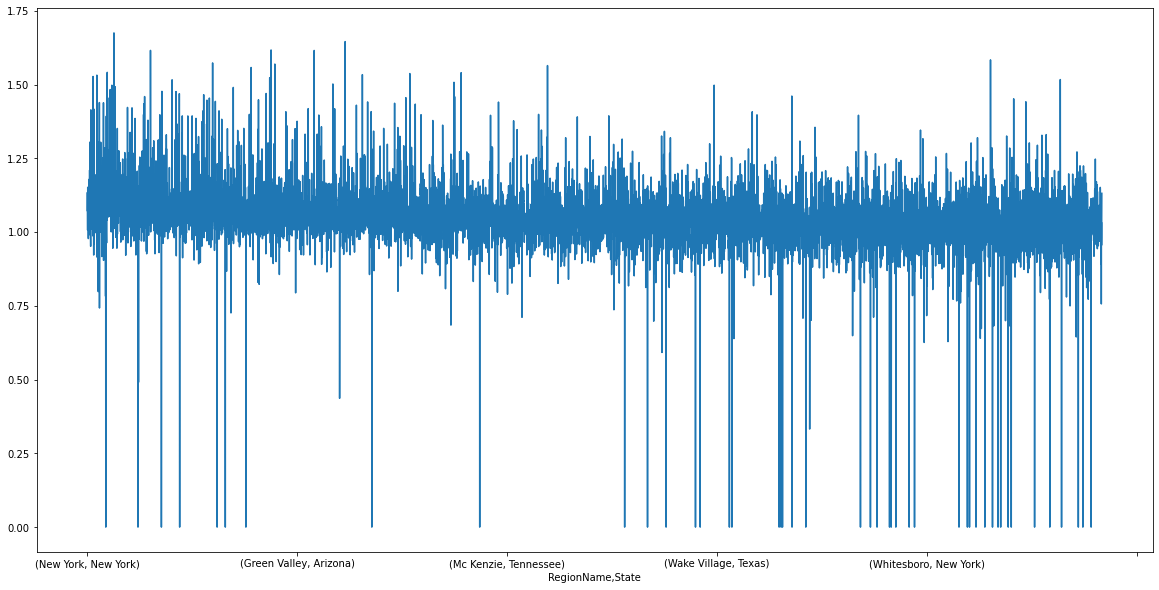

In [79]:
s1.plot()

In [80]:
s2 = TownsUnivs[rStart]/TownsUnivs[rBottom]
#s2.fillna(method='bfill', inplace=True)
s2.dropna(inplace=True)

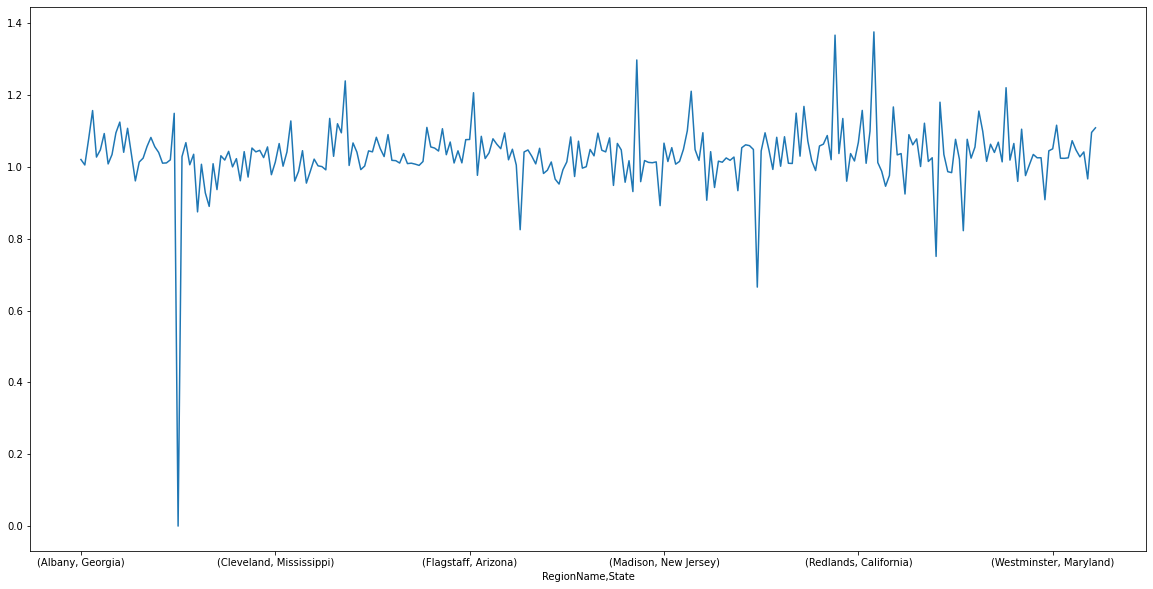

In [81]:
s2.plot()

In [82]:
from scipy import stats

In [85]:
stats.ttest_ind(s1,s2)

Ttest_indResult(statistic=1.9717393503351928, pvalue=0.04866708820686231)

In [ ]:

def run_ttest():
    '''First creates new data showing the decline or growth of housing prices
    between the recession start and the recession bottom. Then runs a ttest
    comparing the university town values to the non-university towns values, 
    return whether the alternative hypothesis (that the two groups are the same)
    is true or not as well as the p-value of the confidence. 
    
    Return the tuple (different, p, better) where different=True if the t-test is
    True at a p<0.01 (we reject the null hypothesis), or different=False if 
    otherwise (we cannot reject the null hypothesis). The variable p should
    be equal to the exact p value returned from scipy.stats.ttest_ind(). The
    value for better should be either "university town" or "non-university town"
    depending on which has a lower mean price ratio (which is equivilent to a
    reduced market loss).
    
    H0 : University town value  = non-university town value
    H1 : University town value != non-university town value
    '''

    # between the recession start and the recession bottom
    # create new data showing the decline or growth of housing prices
    # compare the university town values to the non-university towns values
    # what is the statistic

    # Hypothesis: University towns have their mean housing prices less effected by recessions. 
    # Run a t-test to compare:
    # - the ratio of the mean price of houses in university towns the quarter before the recession starts 
    # - to the recession bottom. 
    # - (price_ratio=quarter_before_recession/recession_bottom)
    
    df = convert_housing_data_to_quarters()
    rStart = get_recession_start()
    rBottom = get_recession_bottom()
    rEnd = get_recession_end()
    sliceDF = df[rStart:rBottom]
 
    return
run_ttest()